# 🧠 Task Definition

The objective of this task is **binary classification** of colonoscopy images to detect the presence of a **lumen**. The model is trained to distinguish between:

- **Lumen present**
- **No lumen present**

This task supports downstream navigation and robotic intervention in endoscopic systems by enabling accurate anatomical localization.

# Data

## 📂 Dataset Description

Two image sets were provided in ZIP format:

- `haslumen/` – images where the lumen is clearly visible  
- `nolumen/` – images lacking visible lumen

### Dataset statistics:
- **Total images**: 10,559  
  - `No Lumen`: 5,090  
  - `Lumen`: 5,469  
- The data was **combined** and split into:
  - **Training**: 80%
  - **Validation**: 10%
  - **Test**: 10%

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!unzip -q "/content/drive/MyDrive/nolumen.zip" -d data
!unzip -q "/content/drive/MyDrive/haslumen.zip" -d data

In [3]:
import os, glob, random
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class LumenDataset(Dataset):
    def __init__(self, filepaths, transform=None):
        self.filepaths = filepaths
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        fp = self.filepaths[idx]
        img = Image.open(fp).convert('RGB')
        if self.transform: img = self.transform(img)
        label = 1 if 'haslumen' in fp else 0
        return img, torch.tensor(label, dtype=torch.float32)

# Prepare file paths
all_files = glob.glob('data/nolumen/*') + glob.glob('data/haslumen/*')
random.shuffle(all_files)
n = len(all_files)
train, val, test = all_files[:int(0.8*n)], all_files[int(0.8*n):int(0.9*n)], all_files[int(0.9*n):]

# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = LumenDataset(train, transform)
val_ds = LumenDataset(val, transform)
test_ds = LumenDataset(test, transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

# Model

## 🔧 Model

### 🏗️ Architecture: SqueezeNet (Custom Head)

We used **SqueezeNet v1.1** with a custom lightweight classification head:

- Final classifier:  
  `Conv2D(512 → 32) → BatchNorm → ReLU → AdaptiveAvgPool2d → Linear(32 → 1)`
- Output is passed to `BCEWithLogitsLoss` for binary classification.
- Trainable params: `739,009`

In [20]:
import torch.nn as nn
import torchvision.models as models
from torchsummary import summary

class SqueezeNetBinary(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = models.squeezenet1_1(pretrained=False)
        self.backbone.classifier = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Conv2d(512, 32, kernel_size=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.fc = nn.Linear(32, 1)
        nn.init.normal_(self.fc.weight, std=0.01)
        nn.init.constant_(self.fc.bias, 0.1)

    def forward(self, x):
        x = self.backbone.features(x)
        x = self.backbone.classifier(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

model = SqueezeNetBinary().to(device)

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Print the model summary
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 111, 111]           1,792
              ReLU-2         [-1, 64, 111, 111]               0
         MaxPool2d-3           [-1, 64, 55, 55]               0
            Conv2d-4           [-1, 16, 55, 55]           1,040
              ReLU-5           [-1, 16, 55, 55]               0
            Conv2d-6           [-1, 64, 55, 55]           1,088
              ReLU-7           [-1, 64, 55, 55]               0
            Conv2d-8           [-1, 64, 55, 55]           9,280
              ReLU-9           [-1, 64, 55, 55]               0
             Fire-10          [-1, 128, 55, 55]               0
           Conv2d-11           [-1, 16, 55, 55]           2,064
             ReLU-12           [-1, 16, 55, 55]               0
           Conv2d-13           [-1, 64, 55, 55]           1,088
             ReLU-14           [-1, 64,

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(


# Train

### 🧬 Training Style

- **From scratch**: No pretrained weights used.
- **Warm-up**: Final head trained for 3 epochs with frozen backbone, followed by full fine-tuning.
- **Optimizer**: SGD with momentum (`lr=0.01`, `momentum=0.9`)  
- **Loss function**: Binary Cross-Entropy with Logits  
- **Epochs**: 15  

In [21]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD([
    {'params': model.fc.parameters()},
    {'params': model.backbone.classifier.parameters()},
], lr=1e-2, momentum=0.9)

# Freeze backbone initially
for p in model.backbone.features.parameters():
    p.requires_grad = False


In [22]:
from sklearn.metrics import accuracy_score
import numpy as np

def train(model, train_loader, val_loader, num_epochs=15, warmup_epochs=3):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        preds_all, labels_all = [], []

        for imgs, labels in train_loader:
            imgs, labels = imgs.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            preds_all += (torch.sigmoid(outputs).detach().cpu().numpy() > 0.5).astype(int).flatten().tolist()
            labels_all += labels.cpu().numpy().flatten().tolist()

        train_acc = accuracy_score(labels_all, preds_all)
        train_loss = running_loss / len(train_loader.dataset)

        # Validation
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for imgs, labels in val_loader:
                imgs = imgs.to(device)
                labels = labels.to(device).float().unsqueeze(1)
                outputs = model(imgs)
                val_preds += (torch.sigmoid(outputs).cpu().numpy() > 0.5).astype(int).flatten().tolist()
                val_labels += labels.cpu().numpy().flatten().tolist()

        val_acc = accuracy_score(val_labels, val_preds)

        print(f"Epoch {epoch+1:2d} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

        # Unfreeze after warmup
        if epoch + 1 == warmup_epochs:
            for p in model.backbone.features.parameters():
                p.requires_grad = True
            optimizer.add_param_group({'params': model.backbone.features.parameters(), 'lr': 1e-3})


In [23]:
train(model, train_loader, val_loader, num_epochs=15, warmup_epochs=3)

Epoch  1 | Train Loss: 0.6353 | Train Acc: 0.6448 | Val Acc: 0.6610
Epoch  2 | Train Loss: 0.5634 | Train Acc: 0.7167 | Val Acc: 0.5521
Epoch  3 | Train Loss: 0.5357 | Train Acc: 0.7397 | Val Acc: 0.7150
Epoch  4 | Train Loss: 0.4998 | Train Acc: 0.7620 | Val Acc: 0.4830
Epoch  5 | Train Loss: 0.4415 | Train Acc: 0.7919 | Val Acc: 0.8239
Epoch  6 | Train Loss: 0.4096 | Train Acc: 0.8127 | Val Acc: 0.8172
Epoch  7 | Train Loss: 0.3871 | Train Acc: 0.8231 | Val Acc: 0.7566
Epoch  8 | Train Loss: 0.3840 | Train Acc: 0.8256 | Val Acc: 0.8362
Epoch  9 | Train Loss: 0.3633 | Train Acc: 0.8383 | Val Acc: 0.7462
Epoch 10 | Train Loss: 0.3553 | Train Acc: 0.8382 | Val Acc: 0.8229
Epoch 11 | Train Loss: 0.3425 | Train Acc: 0.8457 | Val Acc: 0.8523
Epoch 12 | Train Loss: 0.3350 | Train Acc: 0.8506 | Val Acc: 0.6998
Epoch 13 | Train Loss: 0.3318 | Train Acc: 0.8523 | Val Acc: 0.4640
Epoch 14 | Train Loss: 0.3278 | Train Acc: 0.8577 | Val Acc: 0.6771
Epoch 15 | Train Loss: 0.3128 | Train Acc: 0.860

In [24]:
torch.save(model.state_dict(), 'model.pth')

# Evaluation+Sample output

## ✅ Summary

- The model achieves **very high sensitivity (recall)** on the Lumen class (533/546 = 97.6%).
- **Specificity** is lower for No Lumen class due to 225 false positives.
- The imbalance in error types suggests the model is conservative and prioritizes **detecting lumen**, which may be acceptable for medical applications where missing a lumen is more critical than false positives.

---

### 📌 Interpretation:

This lightweight SqueezeNet model, trained from scratch, achieved strong performance:

- Competitive accuracy and F1
- Excellent AUC
- Fast and resource-efficient inference


In [27]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

if not model:
  model = torch.load('model.pth')

model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        preds = torch.sigmoid(outputs).cpu()
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.unsqueeze(1).numpy())

import numpy as np
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

acc = accuracy_score(all_labels, all_preds > 0.5)
f1 = f1_score(all_labels, all_preds > 0.5)
auc = roc_auc_score(all_labels, all_preds)

print(f"Test Accuracy: {acc:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")


Test Accuracy: 0.7746, F1: 0.8175, AUC: 0.9327


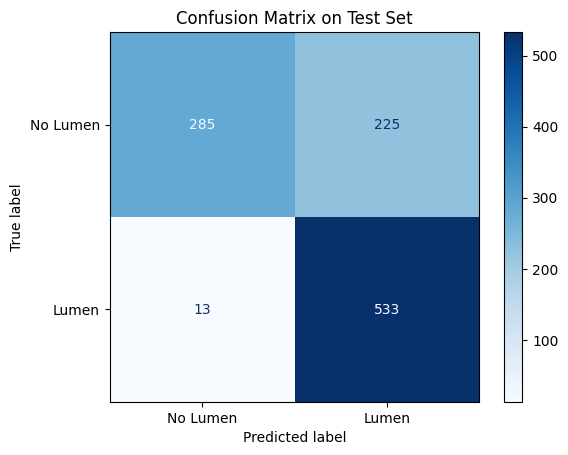

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds > 0.5)

# Display it
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Lumen", "Lumen"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix on Test Set")
plt.show()


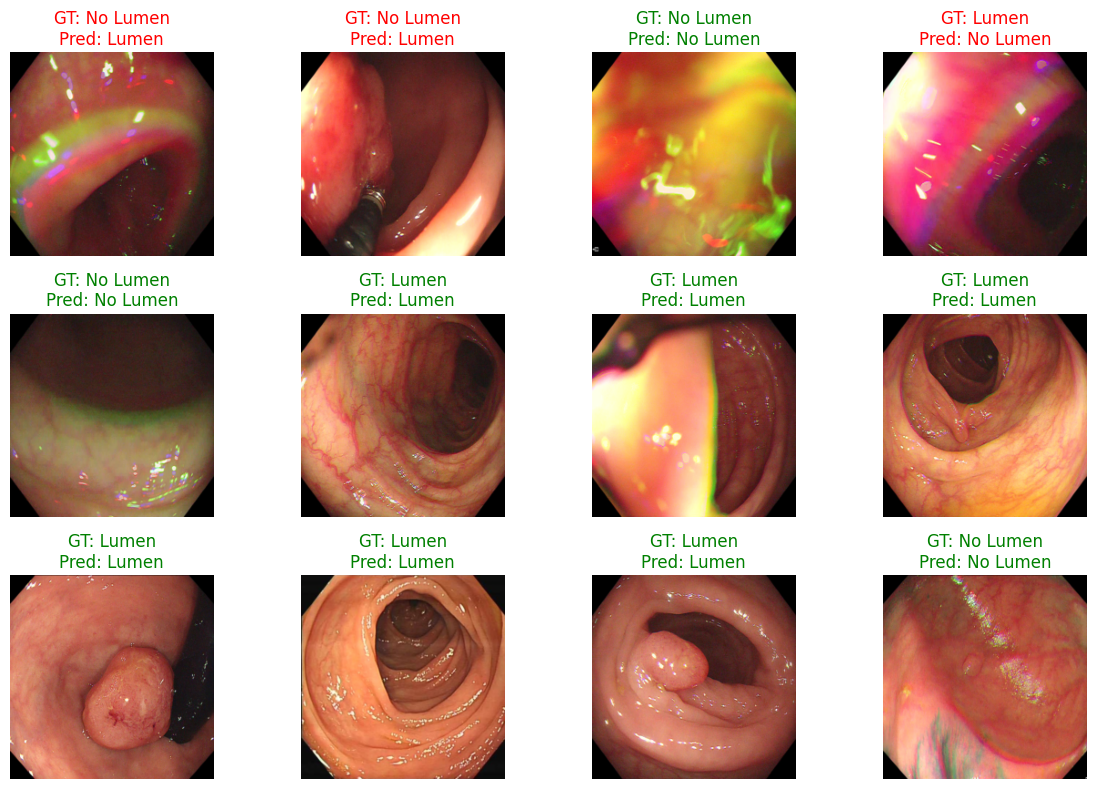

In [28]:
model.eval()
shown = 0
plt.figure(figsize=(12, 8))

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        logits = model(imgs)
        probs = torch.sigmoid(logits).cpu().squeeze()
        preds = (probs > 0.5).int()

        for i in range(len(imgs)):
            if shown >= 12: break  # Display 12 samples

            img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
            img_np = img_np * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]  # Denormalize
            img_np = img_np.clip(0, 1)

            true_label = "Lumen" if labels[i] == 1 else "No Lumen"
            pred_label = "Lumen" if preds[i] == 1 else "No Lumen"
            color = 'green' if true_label == pred_label else 'red'

            plt.subplot(3, 4, shown + 1)
            plt.imshow(img_np)
            plt.title(f"GT: {true_label}\nPred: {pred_label}", color=color)
            plt.axis('off')

            shown += 1
        if shown >= 12: break

plt.tight_layout()
plt.show()
